# <b><font color="#ff7000" letter-spacing= "2px" size="5">CLEANING DATA </span></b>

### 1. Inisialisasi sesi spark dan membuat data frame

In [1]:
from pyspark.sql import SparkSession

# Inisialisasi Spark Session
spark = SparkSession.builder.appName("Analisis dan Visualisasi").getOrCreate()

# Baca file CSV menjadi DataFrame
spark_df = spark.read.csv('reviews.csv', header=True, inferSchema=True)

### 2. Lihat jumlah baris dan kolom</font>

In [2]:
print(f"Jumlah baris: {spark_df.count()}")
print(f"Kolom yang tersedia: {len(spark_df.columns)}")

Jumlah baris: 941512
Kolom yang tersedia: 11


### 3. Lihat skema data frame

In [3]:
# Tampilkan skema DataFrame
spark_df.printSchema()

root
 |-- appVersion: string (nullable = true)
 |-- at: string (nullable = true)
 |-- content: string (nullable = true)
 |-- repliedAt: string (nullable = true)
 |-- replyContent: string (nullable = true)
 |-- reviewCreatedVersion: string (nullable = true)
 |-- reviewId: string (nullable = true)
 |-- score: string (nullable = true)
 |-- thumbsUpCount: string (nullable = true)
 |-- userImage: string (nullable = true)
 |-- userName: string (nullable = true)



### 4. Konversi ke tipe data yang sesuai

In [4]:
from pyspark.sql.functions import col

# Konversi kolom ke tipe integer
spark_df = spark_df.withColumn("score", col("score").cast("integer")) \
                   .withColumn("thumbsUpCount", col("thumbsUpCount").cast("integer"))

# Periksa skema setelah konversi
spark_df.printSchema()

root
 |-- appVersion: string (nullable = true)
 |-- at: string (nullable = true)
 |-- content: string (nullable = true)
 |-- repliedAt: string (nullable = true)
 |-- replyContent: string (nullable = true)
 |-- reviewCreatedVersion: string (nullable = true)
 |-- reviewId: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- thumbsUpCount: integer (nullable = true)
 |-- userImage: string (nullable = true)
 |-- userName: string (nullable = true)



### 5. Menghapus Kolom yang Tidak Dibutuhkan

In [5]:
# Drop kolom yang tidak dibutuhkan
spark_df = spark_df.drop("userImage", "userName", "repliedAt", "replyContent")

# Tampilkan kolom yang tersisa
print(f"Kolom yang tersisa: {len(spark_df.columns)} \n {spark_df.columns}")

Kolom yang tersisa: 7 
 ['appVersion', 'at', 'content', 'reviewCreatedVersion', 'reviewId', 'score', 'thumbsUpCount']


### 6. Cek Missing values

In [6]:
# Cek jumlah nilai kosong di setiap kolom
from pyspark.sql.functions import isnan, when, count

spark_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in spark_df.columns]).show()

+----------+----+-------+--------------------+--------+-----+-------------+
|appVersion|  at|content|reviewCreatedVersion|reviewId|score|thumbsUpCount|
+----------+----+-------+--------------------+--------+-----+-------------+
|    210769|9648|   8840|              225678|   16612|24103|        24361|
+----------+----+-------+--------------------+--------+-----+-------------+



### 7. Penanganan missing values

#### (a) Drop Rows dengan Missing Values

In [7]:
# Drop baris dengan missing values di kolom score atau content
spark_df_cleaned = spark_df.dropna(subset=["score", "content"])

# Periksa kembali jumlah baris setelah dropping
print(f"Jumlah baris sebelum dihapus: {spark_df.count()}")
print(f"Jumlah baris setelah dihapus: {spark_df_cleaned.count()}")

Jumlah baris sebelum dihapus: 941512


Jumlah baris setelah dihapus: 917403


#### (b) Imputasi Nilai Kosong

In [8]:
from pyspark.sql.functions import lit

# Ganti nilai kosong di thumbsUpCount dengan 0, dan di reviewCreatedVersion dengan "unknown"
spark_df_cleaned = spark_df_cleaned.fillna({
    "thumbsUpCount": 0,
    "reviewCreatedVersion": "unknown",
    "appVersion": "unknown"
})

In [9]:
# Cek ulang jumlah baris dan nilai kosong
print(f"Jumlah baris setelah pembersihan: {spark_df_cleaned.count()}")
spark_df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df_cleaned.columns]).show()

Jumlah baris setelah pembersihan: 917403


+----------+---+-------+--------------------+--------+-----+-------------+
|appVersion| at|content|reviewCreatedVersion|reviewId|score|thumbsUpCount|
+----------+---+-------+--------------------+--------+-----+-------------+
|         0|  0|      0|                   0|       0|    0|            0|
+----------+---+-------+--------------------+--------+-----+-------------+



#### (c) Melihat skema

In [10]:
spark_df_cleaned = spark_df_cleaned.withColumn("score", col("score").cast("int"))
spark_df_cleaned = spark_df_cleaned.withColumn("thumbsUpCount", col("thumbsUpCount").cast("int"))
spark_df_cleaned.printSchema()

root
 |-- appVersion: string (nullable = false)
 |-- at: string (nullable = true)
 |-- content: string (nullable = true)
 |-- reviewCreatedVersion: string (nullable = false)
 |-- reviewId: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- thumbsUpCount: integer (nullable = false)



### 8. Analisis Distribusi Skor Review</font>

<font face="TimesNewRoman">Cek distribusi skor (kolom ``score``) untuk memahami sentimen pengguna

In [11]:
spark_df_cleaned.groupBy("score").count().orderBy("score").show()

+-----+------+
|score| count|
+-----+------+
|    0|   171|
|    1|209316|
|    2| 28562|
|    3| 36142|
|    4| 72010|
|    5|571195|
|   11|     1|
|   14|     1|
|   16|     1|
|   24|     1|
|  279|     3|
+-----+------+



> ## <font face="TimesNewRoman">Anomali (outlier)
> <font face="TimesNewRoman">Berdasarkan hasil diatas, ada keanehan dimana nilai skor yang ditampilkan tidak sesuai dengan data yang seharusnya dimana range nya diantara 1 sampai 5

### 9. Filter data berdasarkan score

In [12]:
# Filter review dengan skor dibawah 1 dan diatas lima
score_dibawah_satu = spark_df_cleaned.filter(col("score") < 1)
score_diatas_lima = spark_df_cleaned.filter(col("score") > 5)

# Tampilkan beberapa baris
print(f"Jumlah review dengan skor dibawah satu berjumlah {score_dibawah_satu.count()}")
score_dibawah_satu.show(5)

print(f"Jumlah review dengan skor diatas lima berjumlah {score_diatas_lima.count()}")
score_diatas_lima.show(5)

Jumlah review dengan skor dibawah satu berjumlah 171


+--------------------+--------------------+--------------------+--------------------+--------+-----+-------------+
|          appVersion|                  at|             content|reviewCreatedVersion|reviewId|score|thumbsUpCount|
+--------------------+--------------------+--------------------+--------------------+--------+-----+-------------+
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|c8326bb4-6e3f-4ae...|       5|    0|            0|
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|5b167768-4420-412...|       1|    0|            0|
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|d5aac406-3144-4dd...|       5|    0|            0|
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|34ce0ae4-aa40-443...|       1|    0|            0|
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|0ffc771c-5389-4fb...|       5|    0|            0|
+--------------------+--------------------+--------------------+----------------

Jumlah review dengan skor diatas lima berjumlah 7


+--------------------+--------------------+--------------------+--------------------+--------+-----+-------------+
|          appVersion|                  at|             content|reviewCreatedVersion|reviewId|score|thumbsUpCount|
+--------------------+--------------------+--------------------+--------------------+--------+-----+-------------+
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|f608e067-c8ea-415...|       1|   11|            0|
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|123617ac-94d7-49e...|       3|   24|            0|
|Kami telah memper...| silakan untuk ma...| silahkan hubungi...|ee5e31b3-c3ff-4eb...|       1|   14|            0|
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|58fc2588-2695-49c...|       1|   16|            0|
|Terima kasih atas...| sudah kami catat...| jangan ragu untu...|ba103f06-17b8-4a7...|       2|  279|            0|
+--------------------+--------------------+--------------------+----------------

### 10. Penanganan outlier

In [13]:
spark_df_cleaned = spark_df_cleaned.filter((col("score") >= 1) & (col("score") <= 5))

In [14]:
# Filter review dengan skor dibawah 1 dan diatas lima
score_dibawah_satu = spark_df_cleaned.filter(col("score") < 1)
score_diatas_lima = spark_df_cleaned.filter(col("score") > 5)

# Tampilkan beberapa baris
print(f"Jumlah review dengan skor dibawah satu berjumlah {score_dibawah_satu.count()}")
score_dibawah_satu.show(5)

print(f"Jumlah review dengan skor diatas lima berjumlah {score_diatas_lima.count()}")
score_diatas_lima.show(5)

Jumlah review dengan skor dibawah satu berjumlah 0


+----------+---+-------+--------------------+--------+-----+-------------+
|appVersion| at|content|reviewCreatedVersion|reviewId|score|thumbsUpCount|
+----------+---+-------+--------------------+--------+-----+-------------+
+----------+---+-------+--------------------+--------+-----+-------------+



Jumlah review dengan skor diatas lima berjumlah 0


+----------+---+-------+--------------------+--------+-----+-------------+
|appVersion| at|content|reviewCreatedVersion|reviewId|score|thumbsUpCount|
+----------+---+-------+--------------------+--------+-----+-------------+
+----------+---+-------+--------------------+--------+-----+-------------+



### 11. Analisis Distribusi Skor Review</font>

In [15]:
spark_df_cleaned.groupBy("score").count().orderBy("score").show()

+-----+------+
|score| count|
+-----+------+
|    1|209316|
|    2| 28562|
|    3| 36142|
|    4| 72010|
|    5|571195|
+-----+------+



### 12. Simpan data frame dengan ekstensi file csv

In [16]:
spark_df_cleaned.coalesce(1).write.csv("DataCleaned", header=True, mode="overwrite")

> ## <font face="TimesNewRoman">Note
> 1. <font face = "TimesNewRoman">Untuk atribut ``content`` masih harus dilakukan preprocessing lebih lanjut!  
> 2. <font face = "TimesNewRoman">Disini saya sengaja melewatkannya karena masi mempelajari spark.

# <b> <font size="5" face="TImesNewRoman" color = "Gray">Memuat part DataCleaned (Tampan memulai dari CLEANING DATA)

In [63]:
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import isnan, when, count
#from pyspark.sql.functions import col
#from pyspark.sql.functions import lit
#from textblob import TextBlob
#import matplotlib.pyplot as plt

In [14]:
#from pyspark.sql import SparkSession

#spark = SparkSession.builder.appName("Read DataFrame from Parts").getOrCreate()
#spark_df_cleaned = spark.read.csv("DataCleaned/part-00000-8e3404b6-08b2-45f9-a967-75d8cc0168b8-c000.csv", header=True, inferSchema=True)
#spark_df_cleaned.show(5)

+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+
|  appVersion|                  at|             content|reviewCreatedVersion|            reviewId|score|thumbsUpCount|
+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+
|1.9.43.10342|2024-12-27T09:35:...|game yg bikin gw ...|        1.9.43.10342|48eed574-b912-46b...|    1|           14|
|     unknown|2024-12-27T09:30:...|game busukkk kalh...|             unknown|c23dc87e-ad8e-450...|    5|            0|
|     unknown|2024-12-27T09:17:...|Game busuk bikin ...|             unknown|86a94d14-14e9-4b7...|    1|            0|
|1.9.42.10341|2024-12-27T09:06:...|DAH GADA HARAPAN ...|        1.9.42.10341|7d8c43b1-dc74-490...|    1|           17|
|1.9.42.10341|2024-12-27T08:54:...|Kasih tim yg bene...|        1.9.42.10341|b9b24f8e-8d33-4dd...|    1|            0|
+------------+--------------------+-------------

In [15]:
spark_df_cleaned.printSchema()

root
 |-- appVersion: string (nullable = true)
 |-- at: string (nullable = true)
 |-- content: string (nullable = true)
 |-- reviewCreatedVersion: string (nullable = true)
 |-- reviewId: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- thumbsUpCount: integer (nullable = true)



### Batas

# <b><span style="color:#ff7000; letter-spacing: 1px;" >Transformasi Data Menggunakan TextBlob</span></b>

> #### <font face="TimesNewRoman"><b>Tanpa preprocessing!</b>

In [16]:
from textblob import TextBlob

# Fungsi untuk analisis sentimen
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Ubah konten menjadi sentimen
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

sentiment_udf = udf(get_sentiment, FloatType())
spark_df_cleaned = spark_df_cleaned.withColumn("sentiment", sentiment_udf(col("content")))

In [17]:
spark_df_cleaned.show(10)

+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+-----------+
|  appVersion|                  at|             content|reviewCreatedVersion|            reviewId|score|thumbsUpCount|  sentiment|
+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+-----------+
|1.9.43.10342|2024-12-27T09:35:...|game yg bikin gw ...|        1.9.43.10342|48eed574-b912-46b...|    1|           14|       -0.4|
|     unknown|2024-12-27T09:30:...|game busukkk kalh...|             unknown|c23dc87e-ad8e-450...|    5|            0|       -0.4|
|     unknown|2024-12-27T09:17:...|Game busuk bikin ...|             unknown|86a94d14-14e9-4b7...|    1|            0|       -0.3|
|1.9.42.10341|2024-12-27T09:06:...|DAH GADA HARAPAN ...|        1.9.42.10341|7d8c43b1-dc74-490...|    1|           17|        0.0|
|1.9.42.10341|2024-12-27T08:54:...|Kasih tim yg bene...|        1.9.42.10341|b9b24f

### (a) Melihat Skema

In [18]:
spark_df_cleaned.printSchema()

root
 |-- appVersion: string (nullable = true)
 |-- at: string (nullable = true)
 |-- content: string (nullable = true)
 |-- reviewCreatedVersion: string (nullable = true)
 |-- reviewId: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- thumbsUpCount: integer (nullable = true)
 |-- sentiment: float (nullable = true)



<font face="TimesNewRoman">Dari skema diatas, tipe data atribut ``sentiment`` sudah sesuai "``float``"

### (b) Memfilter DataFrame berdasarkan nilai kolom sentiment
``klasifikasi data berdasarkan polaritas sentimen``

In [19]:
# Filter sentiment positif, negatif dan netral berdasarkan 
sentiment_positif = spark_df_cleaned.filter(col("sentiment") > 0)
sentiment_negatif = spark_df_cleaned.filter(col("sentiment") < 0)
sentiment_netral = spark_df_cleaned.filter(col("sentiment") == 0)

### (c) Menghitung jumlah baris untuk masing-masing kategori sentimen

In [20]:
total_positif = sentiment_positif.count()
total_negatif = sentiment_negatif.count()
total_netral  = sentiment_netral.count()

# Tampilkan beberapa baris
print(f"Total jumlah sentimen Positif = {total_positif}")
print(f"Total jumlah sentimen Negatif = {total_negatif}")
print(f"Total jumlah sentimen Netral  = {total_netral}")

Total jumlah sentimen Positif = 108584
Total jumlah sentimen Negatif = 280883
Total jumlah sentimen Netral  = 527758


# <b><span style="color:#ff7000; letter-spacing: 1.5px;" >Visualisasi menggunakan piechart</span></b>

#### (a) Menampilkan jumlah dan persentase sentiment

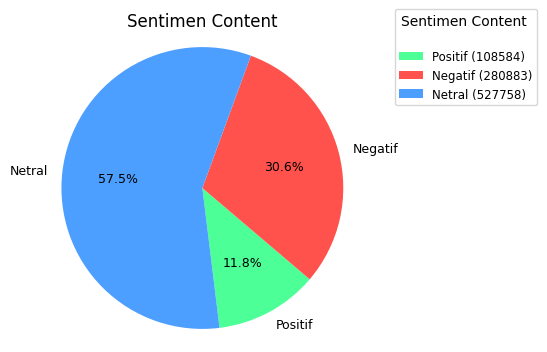

In [61]:
import matplotlib.pyplot as plt

# Data untuk visualisasi
labels = ['Positif', 'Negatif', 'Netral']
sizes = [total_positif,total_negatif,total_netral]
colors = ['#4cff96','#ff524c','#4c9eff']

# Menghitung persentase
total = sum(sizes)
persen = [f"{label} ({size})" for label, size in zip(labels, sizes)]

# Membuat pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    sizes, labels=labels, colors=colors, 
    autopct='%1.1f%%', startangle=-83, textprops={'fontsize': 9}
)
plt.title('Sentimen Content')
plt.legend(persen, title="Sentimen Content \n", fontsize = 8.5, loc="upper right", bbox_to_anchor=(1.6, 1.1))
plt.axis('equal')  # Pastikan pie chart berbentuk lingkaran
plt.show()

#### (b) Memfilter persentase jumlah rating terbanyak</font>

In [22]:
# Filter bintang (Rating atau Score)
bintang1 = spark_df_cleaned.filter(col("score") == 1)
bintang2 = spark_df_cleaned.filter(col("score") == 2)
bintang3 = spark_df_cleaned.filter(col("score") == 3)
bintang4 = spark_df_cleaned.filter(col("score") == 4)
bintang5 = spark_df_cleaned.filter(col("score") == 5)

# htung bintang (rating atau score)
b1 = bintang1.count()
b2 = bintang2.count()
b3 = bintang3.count()
b4 = bintang4.count()
b5 = bintang5.count()

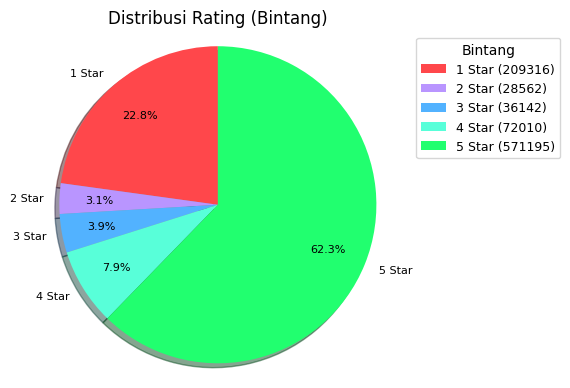

In [23]:
import matplotlib.pyplot as plt
import random
# Data untuk visualisasi
labels = ['1 Star', '2 Star', '3 Star','4 Star','5 Star']
bintang = [b1, b2, b3, b4, b5]

colors = ['#ff474b', '#b995ff', '#52b2ff', '#58ffd9', '#21ff6f']

# Menghitung persentase
jumlah_total = sum(bintang)
#persentasi = [f"{label} ({size / total * 100:.1f}%)" for label, size in zip(labels, jumlah_total)]
total = [f"{label} ({size})" for label, size in zip(labels, bintang)]

# Membuat pie chart
plt.figure(figsize=(4.5,4.5))
plt.pie(
    bintang, #explode = (0.03, 0.03, 0.03, 0.03, 0.03), 
    labels=labels, colors=colors, pctdistance=0.75, 
    autopct='%1.1f%%', shadow=True, startangle=90, 
    labeldistance=1.10, textprops={'fontsize': 8}
)
plt.title('Distribusi Rating (Bintang)')
plt.legend(total, title="Bintang", loc="upper right", fontsize = 9, bbox_to_anchor=(1.5, 1) )
plt.axis('equal')  # Pastikan pie chart berbentuk lingkaran
plt.show()

### # Menampilkan isi dataset

In [24]:
spark_df_cleaned.show(5)

+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+---------+
|  appVersion|                  at|             content|reviewCreatedVersion|            reviewId|score|thumbsUpCount|sentiment|
+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+---------+
|1.9.43.10342|2024-12-27T09:35:...|game yg bikin gw ...|        1.9.43.10342|48eed574-b912-46b...|    1|           14|     -0.4|
|     unknown|2024-12-27T09:30:...|game busukkk kalh...|             unknown|c23dc87e-ad8e-450...|    5|            0|     -0.4|
|     unknown|2024-12-27T09:17:...|Game busuk bikin ...|             unknown|86a94d14-14e9-4b7...|    1|            0|     -0.3|
|1.9.42.10341|2024-12-27T09:06:...|DAH GADA HARAPAN ...|        1.9.42.10341|7d8c43b1-dc74-490...|    1|           17|      0.0|
|1.9.42.10341|2024-12-27T08:54:...|Kasih tim yg bene...|        1.9.42.10341|b9b24f8e-8d33-4dd...

### # Mengurutkan DataFrame 
> Short Ascending Berdasarkan thumpsUpCount (Dari terbesar hingga terkecil)

In [25]:
# Mengurutkan DataFrame berdasarkan thumbsUpCount secara menurun
sorted_df = spark_df_cleaned.orderBy(col('thumbsUpCount').desc())

# Menampilkan 5 data teratas setelah diurutkan
sorted_df.show(5)

+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+-----------+
|  appVersion|                  at|             content|reviewCreatedVersion|            reviewId|score|thumbsUpCount|  sentiment|
+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+-----------+
| 19.2.21.104|2024-11-10T13:26:...|Makin kesini maki...|         19.2.21.104|d11d2c3c-3e24-45e...|    1|        43813|      -0.15|
|1.9.29.10113|2024-11-13T13:12:...|Tolong Perbaiki l...|        1.9.29.10113|a041ecd7-8baf-47c...|    1|        21292|-0.34444445|
|1.9.29.10113|2024-11-09T11:42:...|Bagus sih tapi cu...|        1.9.29.10113|32fff8c0-e93a-48b...|    5|        20491| 0.33333334|
| 19.2.11.103|2024-09-20T23:02:...|Game nya sih udah...|         19.2.11.103|e04cdb0e-ce3e-49c...|    5|        15169|       -0.2|
| 19.2.11.103|2024-09-20T23:02:...|Game nya sih udah...|         19.2.11.103|e04cdb

> ### Menampilkan Top 10
> ``Pengurutan Descending (Menurun)``

## Top 10

``Mengambil top 10 data dengan jumlah thumbsUpCount terbanyak``

In [37]:
# Mengambil 10 data teratas sebagai list
topTen_list = sorted_df.limit(10).collect()

# Membuat kembali menjadi Spark DataFrame
df_topTEN = spark.createDataFrame(topTen_list)

# Menampilkan top 10 dalam bentuk data frame
df_topTEN.show()

+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+--------------------+
|  appVersion|                  at|             content|reviewCreatedVersion|            reviewId|score|thumbsUpCount|           sentiment|
+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+--------------------+
| 19.2.21.104|2024-11-10T13:26:...|Makin kesini maki...|         19.2.21.104|d11d2c3c-3e24-45e...|    1|        43813|-0.15000000596046448|
|1.9.29.10113|2024-11-13T13:12:...|Tolong Perbaiki l...|        1.9.29.10113|a041ecd7-8baf-47c...|    1|        21292| -0.3444444537162781|
|1.9.29.10113|2024-11-09T11:42:...|Bagus sih tapi cu...|        1.9.29.10113|32fff8c0-e93a-48b...|    5|        20491|  0.3333333432674408|
| 19.2.11.103|2024-09-20T23:02:...|Game nya sih udah...|         19.2.11.103|e04cdb0e-ce3e-49c...|    5|        15169|-0.20000000298023224|
| 19.2.11.103|2024-0

### Untuk perbandingan ``sentiment content`` dan ``sentiment score`` (rating)

In [38]:
# Filter sentiment positif, negatif dan netral berdasarkan score
rating_positif = sorted_df.filter(col("score") > 3)
rating_negatif = sorted_df.filter(col("score") < 3)
rating_netral = sorted_df.filter(col("score") == 3)

In [39]:
total_rating_positif = rating_positif.count()
total_rating_negatif = rating_negatif.count()
total_rating_netral  = rating_netral.count()

# Menampilkan hasil perhitungan score (rating)
print(f"Total jumlah rating Positif = {total_rating_positif}")
print(f"Total jumlah rating Negatif = {total_rating_negatif}")
print(f"Total jumlah rating Netral  = {total_rating_netral}")

Total jumlah rating Positif = 643205
Total jumlah rating Negatif = 237878
Total jumlah rating Netral  = 36142


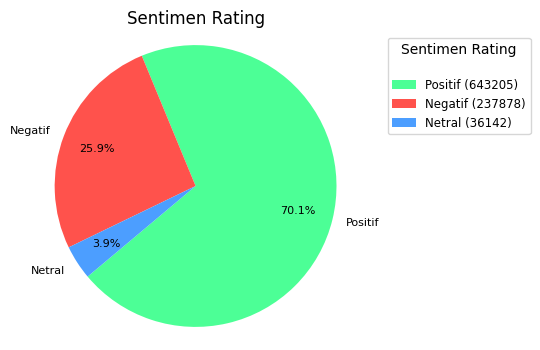

In [62]:
import matplotlib.pyplot as plt

# Data untuk visualisasi
labels = ['Positif', 'Negatif', 'Netral']
sizes = [total_rating_positif,total_rating_negatif,total_rating_netral]
colors = ['#4cff96','#ff524c','#4c9eff']

# Menghitung persentase
total = sum(sizes)
persen = [f"{label} ({size})" for label, size in zip(labels, sizes)]

# Membuat pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    sizes, labels=labels, colors=colors, pctdistance=0.75, 
    autopct='%1.1f%%', startangle=-140, textprops={'fontsize': 8}
)
plt.title('Sentimen Rating')
plt.legend(persen, title="Sentimen Rating\n", fontsize = 8.5, loc="upper right", bbox_to_anchor=(1.6, 1))
plt.axis('equal')  # Pastikan pie chart berbentuk lingkaran
plt.show()

<hr>

> #  <b><font size="4.5" color="Gray">Ini adalah batas akhir dari pengerjaan!</font></b>

<hr>

# <b><font face = "TimesNewRoman" size="6" color="#e1e1e1"><span style="background-color:#e65305">Berdasarkan hasil perhitungan dan visualisasi

> ### ``Sentiment content``
<img src="img/Sentiment_content_vis.jpg" width="500" height="550"></img>

<hr>

> ### ``Sentiment Rating``
<img src="img/Sentiment_rating_vis.jpg" width="500" height="550">